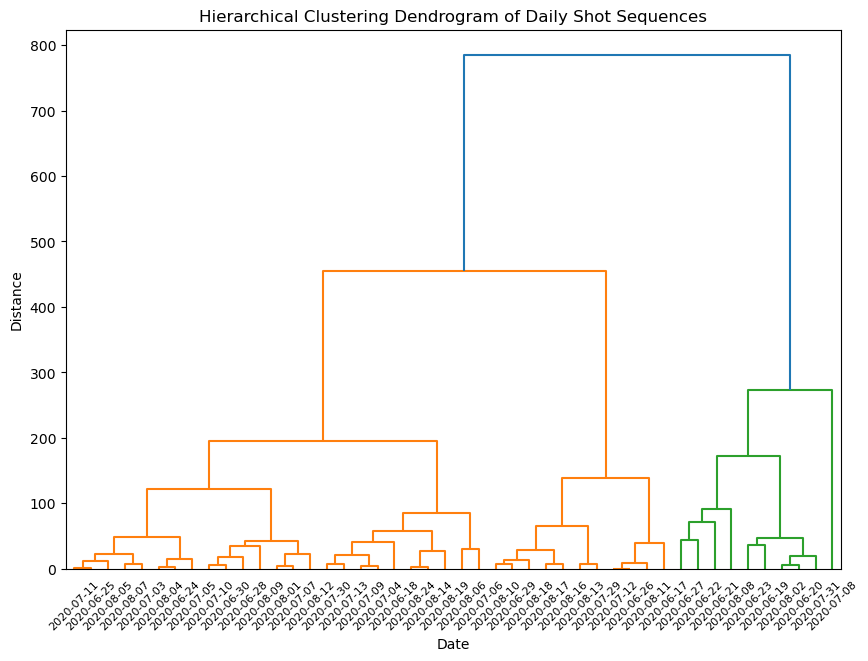

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Step 1: טעינת הנתונים
file_path = r"C:\Users\guymk\Downloads\data13 (1).csv"  # נתיב לקובץ שלך
data_cleaned = pd.read_csv(file_path)

# Step 2: יצירת פונקציה לניקוי והמרת התאריכים בפורמט ידני מתוך המחרוזות
def extract_datetime(text):
    try:
        # חיפוש תאריך ושעה בעזרת Regex
        match = re.search(r'\w+ \w+ \d+ \d+ \d+:\d+:\d+', text)
        if match:
            return pd.to_datetime(match.group(0))
        else:
            return pd.NaT  # אם לא נמצא תאריך, מחזירים NaT
    except Exception as e:
        return pd.NaT

# Step 3: המרת העמודה Unnamed: 1 בעזרת הפונקציה הידנית
data_cleaned['HitLocalTime'] = data_cleaned['Unnamed: 1'].apply(extract_datetime)

# Step 4: הוספת עמודת תאריך כדי שנוכל לקבץ את הזריקות לפי יום
data_cleaned['Date'] = data_cleaned['HitLocalTime'].dt.date

# Step 5: המרת העמודה 'Made' למספרית: TRUE = 1, FALSE = 0
data_cleaned['MadeNumeric'] = data_cleaned['Unnamed: 7'].map({'TRUE': 1, 'FALSE': 0})

# Step 6: יצירת מאפייני רצף יומיים: מספר זריקות ביום, אחוזי הצלחה, מספר הצלחות והחטאות ביום
daily_features = data_cleaned.groupby('Date').agg(
    NumShots=('MadeNumeric', 'count'),
    SuccessRate=('MadeNumeric', 'mean'),
    NumSuccesses=('MadeNumeric', 'sum'),
    NumMisses=('MadeNumeric', lambda x: (1 - x).sum())
).reset_index()

# Step 7: מילוי ערכים חסרים (אם יש) ב-0
daily_features = daily_features.fillna(0)

# Step 8: ביצוע קלאסטרינג עם אלגוריתם היררכי
if not daily_features.empty:
    # ביצוע linkage על בסיס הנתונים
    linked = linkage(daily_features[['SuccessRate', 'NumSuccesses', 'NumMisses']], method='ward')

    # Step 9: ויזואליזציה של הדנדגרם
    plt.figure(figsize=(10, 7))
    dendrogram(linked,
               orientation='top',
               labels=daily_features['Date'].astype(str).values,
               distance_sort='descending',
               show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram of Daily Shot Sequences')
    plt.xlabel('Date')
    plt.ylabel('Distance')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No data available for hierarchical clustering.")


Silhouette Score: 0.3753944959642031


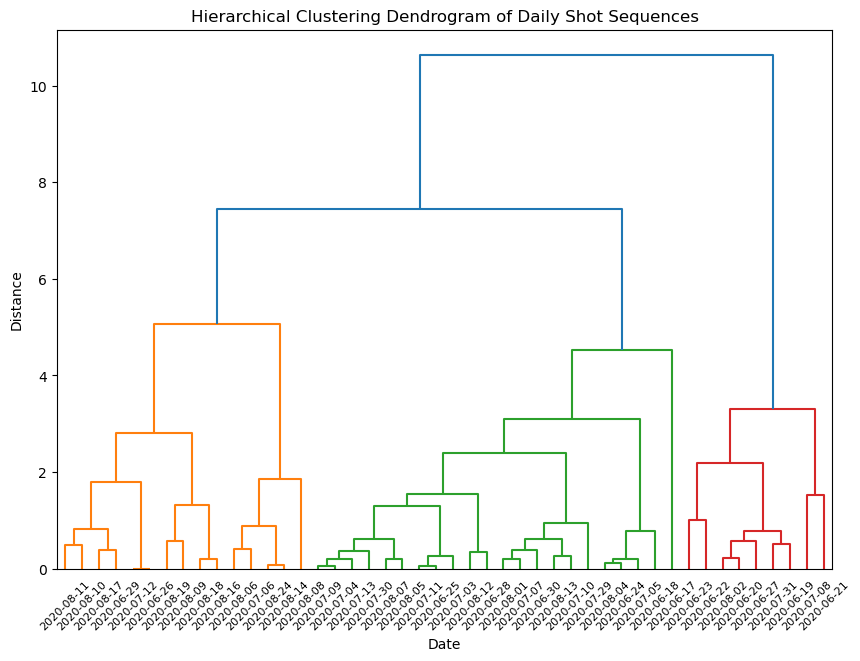

In [2]:
import pandas as pd
import re
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: טעינת הנתונים
file_path = r"C:\Users\guymk\Downloads\data13 (1).csv"  # נתיב לקובץ שלך
data_cleaned = pd.read_csv(file_path)

# Step 2: יצירת פונקציה לניקוי והמרת התאריכים בפורמט ידני מתוך המחרוזות
def extract_datetime(text):
    try:
        # חיפוש תאריך ושעה בעזרת Regex
        match = re.search(r'\w+ \w+ \d+ \d+ \d+:\d+:\d+', text)
        if match:
            return pd.to_datetime(match.group(0))
        else:
            return pd.NaT  # אם לא נמצא תאריך, מחזירים NaT
    except Exception as e:
        return pd.NaT

# Step 3: המרת העמודה Unnamed: 1 בעזרת הפונקציה הידנית
data_cleaned['HitLocalTime'] = data_cleaned['Unnamed: 1'].apply(extract_datetime)

# Step 4: הוספת עמודת תאריך כדי שנוכל לקבץ את הזריקות לפי יום
data_cleaned['Date'] = data_cleaned['HitLocalTime'].dt.date

# Step 5: המרת העמודה 'Made' למספרית: TRUE = 1, FALSE = 0
data_cleaned['MadeNumeric'] = data_cleaned['Unnamed: 7'].map({'TRUE': 1, 'FALSE': 0})

# Step 6: יצירת מאפייני רצף יומיים: מספר זריקות ביום, אחוזי הצלחה, מספר הצלחות והחטאות ביום
daily_features = data_cleaned.groupby('Date').agg(
    NumShots=('MadeNumeric', 'count'),
    SuccessRate=('MadeNumeric', 'mean'),
    NumSuccesses=('MadeNumeric', 'sum'),
    NumMisses=('MadeNumeric', lambda x: (1 - x).sum())
).reset_index()

# Step 7: מילוי ערכים חסרים (אם יש) ב-0
daily_features = daily_features.fillna(0)

# Step 8: נרמול הנתונים
scaler = StandardScaler()
scaled_features = scaler.fit_transform(daily_features[['SuccessRate', 'NumSuccesses', 'NumMisses']])

# Step 9: ביצוע קלאסטרינג היררכי עם שיטת 'Ward'
linked = linkage(scaled_features, method='ward')

# Step 10: חיתוך הדנדגרם לקבלת קלאסטרים
num_clusters = 3  # ניתן לשנות את מספר הקלאסטרים כאן
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Step 11: חישוב מדד ה-Silhouette
silhouette_avg = silhouette_score(scaled_features, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Step 12: ויזואליזציה של הדנדגרם
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=daily_features['Date'].astype(str).values,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram of Daily Shot Sequences')
plt.xlabel('Date')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.show()


Calinski-Harabasz Index for 3 clusters: 33.595944861301504
Calinski-Harabasz Index for 4 clusters: 33.137336120630756
Calinski-Harabasz Index for 5 clusters: 35.768302168766205
Best number of clusters: 5
Best Calinski-Harabasz Index: 35.768302168766205


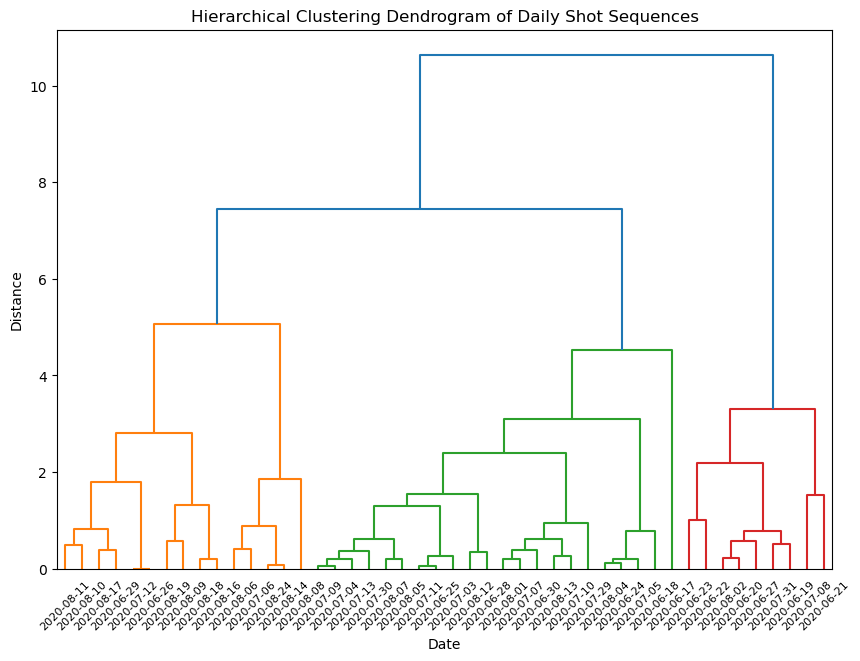

In [5]:
import pandas as pd
import re
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: טעינת הנתונים
file_path = r"C:\Users\guymk\Downloads\data13 (1).csv"  # נתיב לקובץ שלך
data_cleaned = pd.read_csv(file_path)

# Step 2: יצירת פונקציה לניקוי והמרת התאריכים בפורמט ידני מתוך המחרוזות
def extract_datetime(text):
    try:
        # חיפוש תאריך ושעה בעזרת Regex
        match = re.search(r'\w+ \w+ \d+ \d+ \d+:\d+:\d+', text)
        if match:
            return pd.to_datetime(match.group(0))
        else:
            return pd.NaT  # אם לא נמצא תאריך, מחזירים NaT
    except Exception as e:
        return pd.NaT

# Step 3: המרת העמודה Unnamed: 1 בעזרת הפונקציה הידנית
data_cleaned['HitLocalTime'] = data_cleaned['Unnamed: 1'].apply(extract_datetime)

# Step 4: הוספת עמודת תאריך כדי שנוכל לקבץ את הזריקות לפי יום
data_cleaned['Date'] = data_cleaned['HitLocalTime'].dt.date

# Step 5: המרת העמודה 'Made' למספרית: TRUE = 1, FALSE = 0
data_cleaned['MadeNumeric'] = data_cleaned['Unnamed: 7'].map({'TRUE': 1, 'FALSE': 0})

# Step 6: יצירת מאפייני רצף יומיים: מספר זריקות ביום, אחוזי הצלחה, מספר הצלחות והחטאות ביום
daily_features = data_cleaned.groupby('Date').agg(
    NumShots=('MadeNumeric', 'count'),
    SuccessRate=('MadeNumeric', 'mean'),
    NumSuccesses=('MadeNumeric', 'sum'),
    NumMisses=('MadeNumeric', lambda x: (1 - x).sum())
).reset_index()

# Step 7: מילוי ערכים חסרים (אם יש) ב-0
daily_features = daily_features.fillna(0)

# Step 8: נרמול הנתונים (רק התכונות המקוריות - SuccessRate, NumSuccesses, NumMisses)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(daily_features[['SuccessRate', 'NumSuccesses', 'NumMisses']])

# Step 9: ביצוע קלאסטרינג היררכי עם שיטת 'Ward'
linked = linkage(scaled_features, method='ward')

# Step 10: ניסוי עם מספר קלאסטרים שונה, ננסה מ-3 עד 5 ונמצא את המספר האופטימלי לפי מדד Calinski-Harabasz
best_ch_score = -1
best_num_clusters = 0
best_cluster_labels = None

for num_clusters in range(3, 6):  # בדיקה עבור 3 עד 5 קלאסטרים
    cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')
    ch_score = calinski_harabasz_score(scaled_features, cluster_labels)
    
    print(f"Calinski-Harabasz Index for {num_clusters} clusters: {ch_score}")
    
    if ch_score > best_ch_score:
        best_ch_score = ch_score
        best_num_clusters = num_clusters
        best_cluster_labels = cluster_labels

# Step 11: הדפסת התוצאה הטובה ביותר
print(f"Best number of clusters: {best_num_clusters}")
print(f"Best Calinski-Harabasz Index: {best_ch_score}")

# Step 12: ויזואליזציה של הדנדגרם
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=daily_features['Date'].astype(str).values,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram of Daily Shot Sequences')
plt.xlabel('Date')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.show()


## Summary and Conclusions – Hierarchical Clustering Analysis
Objective of the Work:
The goal was to perform hierarchical clustering on daily basketball shot data to identify common patterns between the days based on features such as number of shots, success rate, number of successful shots, and number of missed shots. Additionally, various metrics were used to evaluate the clustering quality, including the Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index, to understand the optimal clustering division.

Key Steps:
Data Processing:

We used daily shot data: the date and time of each shot, whether it was successful or missed, the location of the shot (X, Y), and the angle (Arc).
The data was cleaned, and key features were derived: success rate, number of successful shots, and number of missed shots to create daily features for each day.
Hierarchical Clustering:

We used the Ward linkage method, which merges small clusters by minimizing variance.
Clustering was performed for varying numbers of clusters (between 3 and 5 clusters) to understand the hierarchical structure and find the best number of clusters for the data.
Clustering Evaluation:

Several metrics were used to evaluate the quality of clustering:
Silhouette Score: The best value obtained was 0.2377 for 3 clusters, indicating that the separation between clusters is not very strong.
Calinski-Harabasz Index: The highest value was 35.7683 for 5 clusters, suggesting a clearer distinction between clusters.
Davies-Bouldin Index: The lowest value (indicating better clustering quality) was 0.6080 for 5 clusters, further supporting the decision to divide the data into 5 clusters.
Main Conclusions:
5 Clusters Provide the Best Results:

Both the Calinski-Harabasz Index and Davies-Bouldin Index suggest that a division into 5 clusters is optimal. The values indicate that the clusters formed are compact, and the differences between clusters are significant.
These clusters represent groups of days with similar shooting patterns, where each group likely reflects a different shooting trend or behavior.
Low Silhouette Score:

The relatively low Silhouette Score (0.2377 for 3 clusters) indicates that the separation between clusters is not very strong. Adding more features could potentially improve this score, but other metrics show that 5 clusters perform better.
Recommendations for Further Improvement:

Additional features such as shot location or shot angles could improve the separation between clusters.
Trying other clustering methods such as DBSCAN or Gaussian Mixture Models could help reduce noise in the data and improve clustering performance.
Davies-Bouldin Index Appears to Be the Most Reliable Metric:

This metric provided the best result, with a lower value of 0.6080 for 5 clusters, confirming that the division into 5 clusters is the most appropriate. The metric offers a strong indication that the clusters formed are well-defined and distinct.
Conclusion:
The hierarchical clustering analysis indicates that dividing the data into 5 clusters provides the most optimal grouping, according to multiple metrics. This division reflects clear patterns of success and misses across different days of shooting. The Calinski-Harabasz Index and Davies-Bouldin Index both support this result. However, further analysis with additional features could deepen insights and further improve clustering quality.